In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/datasnaek/mbti-type')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dimitriosliakos
Your Kaggle Key: ··········


100%|██████████| 24.4M/24.4M [00:00<00:00, 125MB/s] 


In [ ]:
!pip3 install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.7 MB/s eta 0:00:00


## Importing the dataset and splitting the data

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# reading the dataset
df = pd.read_csv(os.path.join("/content/mbti-type/mbti_1.csv"))


# splitting data into training and holdout dataset
personality_data, personality_val = train_test_split(
    df, random_state=42, test_size=0.01, stratify=df["type"]
)


## To handle the class imbalance more effectively, we optimize the conversion of the 16 classes into 4 more balanced classes.

In [ ]:
personality_data["is_Extrovert"] = (personality_data["type"].str[0] == "E").astype(int)
personality_data["is_Sensing"] = (personality_data["type"].str[1] == "S").astype(int)
personality_data["is_Thinking"] = (personality_data["type"].str[2] == "T").astype(int)
personality_data["is_Judging"] = (personality_data["type"].str[3] == "J").astype(int)

personality_data = personality_data[["type", "is_Extrovert", "is_Sensing", "is_Thinking", "is_Judging", "posts"]]
personality_data.head()



,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts
7888,INFJ,0,0,0,1,'When asked of the things you wish you did ear...
5944,INFJ,0,0,0,1,'I love both and they are equally important to...
128,INFJ,0,0,0,1,Really? You think implying that everyone who i...
6721,ENFJ,1,0,0,1,'Love is a crazy thing. Se is our best form ...
3565,INTP,0,0,1,0,'I am a physics undergrad with a computation e...


## Class Distribution Analysis for Balanced Classes

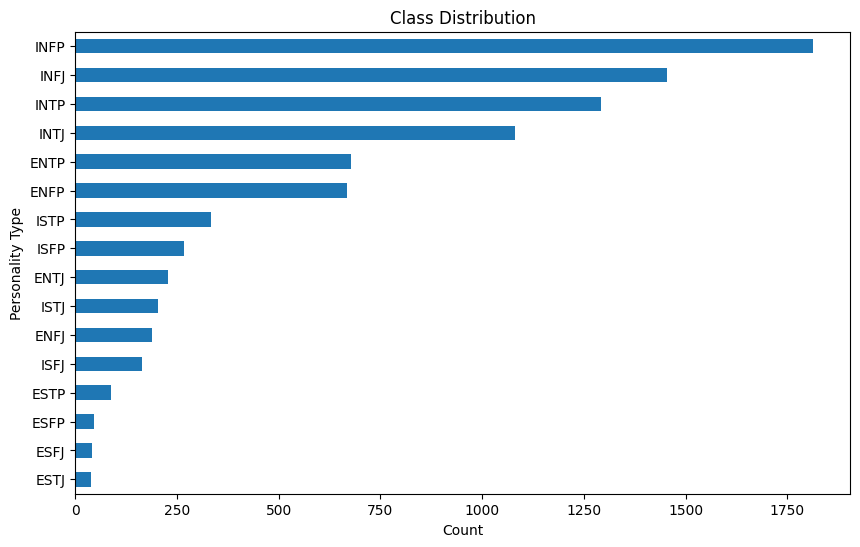

In [ ]:
import matplotlib.pyplot as plt

class_counts = personality_data['type'].value_counts()


plt.figure(figsize=(10, 6))
class_counts.sort_values().plot(kind='barh')
plt.title('Class Distribution')
plt.xlabel('Count')
plt.ylabel('Personality Type')
plt.show()


## Checking for the presence of correlations

<ipython-input-7-c8ca6cc2ac94>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = personality_data.corr()


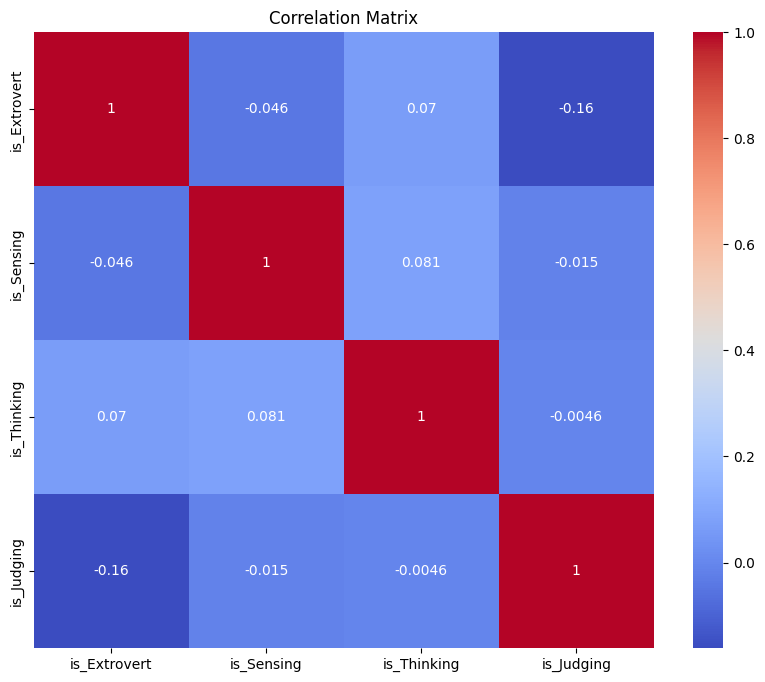

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataset is stored in a pandas DataFrame called 'data'
correlation_matrix = personality_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Feature Engineering - Data Cleaning and Sentiment Analysis

## Data Cleaning

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

# Download required resources
nltk.download('stopwords')
nltk.download('wordnet')

# Define stopwords and lemmatizer
stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean and preprocess text
def clean_text(text):
    # Remove links
    text = re.sub(r'http\S+|https\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text into individual words
    words = text.split()

    # Remove stopwords and perform lemmatization
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]

    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(cleaned_words)

    return cleaned_text

# Apply the clean_text function to the 'posts' column
personality_data['cleaned_posts'] = personality_data['posts'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Sentiments Analysis Score

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Create an instance of the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Perform sentiment analysis on each post with a progress bar
sentiment_scores = []
with tqdm(total=len(personality_data["cleaned_posts"]), desc="Sentiment Analysis") as pbar:
    for post in personality_data["cleaned_posts"]:
        scores = analyzer.polarity_scores(post)
        sentiment_scores.append(scores)
        pbar.update(1)



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
Sentiment Analysis: 100%|██████████| 8588/8588 [01:49<00:00, 78.49it/s]


In [ ]:
from tqdm import tqdm

# Create empty lists for sentiment scores
compound_sent = []
positive_sent = []
neutral_sent = []
negative_sent = []


# Perform sentiment analysis with a progress bar
with tqdm(total=len(personality_data["cleaned_posts"]), desc="Sentiment Analysis") as pbar:
    for post in personality_data["cleaned_posts"]:
        score = analyzer.polarity_scores(post)
        compound_sent.append(score["compound"])
        positive_sent.append(score["pos"])
        neutral_sent.append(score["neu"])
        negative_sent.append(score["neg"])

        pbar.update(1)

# Assign the sentiment scores to the DataFrame
personality_data["compound_sentiment"] = compound_sent
personality_data["positive_sentiment"] = positive_sent
personality_data["neutral_sentiment"] = neutral_sent
personality_data["negative_sentiment"] = negative_sent




Sentiment Analysis: 100%|██████████| 8588/8588 [01:46<00:00, 80.80it/s]


In [ ]:
from sklearn.preprocessing import StandardScaler

sentiment_columns = ["compound_sentiment", "positive_sentiment","neutral_sentiment", "negative_sentiment" ]

# Scale the sentiment scores using MinMaxScaler
scaler = StandardScaler()
personality_data[sentiment_columns] = scaler.fit_transform(personality_data[sentiment_columns])



# Feature Engineering for Personality Data: Additional Features and Counts

In [ ]:
from tqdm import tqdm
import numpy as np
import re

# Function to calculate the ratio of unique words in a post
def unique_words(post):
    unique = set(post.split())
    return len(unique) / 50

# Function to count the number of emojis in a post
def emojis(post):
    emoji_count = sum(1 for word in post.split() if "http" not in word and word.count(":") == 2)
    return emoji_count / 50

# Function to count the number of colons in a post
def colons(post):
    colon_count = sum(word.count(":") for word in post.split() if "http" not in word)
    return colon_count / 50

# Calculate various features for personality_data
personality_data["qm"] = personality_data["posts"].str.count("\?") / 50
personality_data["em"] = personality_data["posts"].str.count("!") / 50
personality_data["colons"] = personality_data["posts"].apply(colons)
personality_data["emojis"] = personality_data["posts"].apply(emojis)

personality_data["word_count"] = personality_data["posts"].str.split().apply(len) / 50
personality_data["unique_words"] = personality_data["posts"].apply(unique_words)

# Calculate post length variance
post_lengths = [len(post.split()) for posts in personality_data["posts"] for post in posts.split("|||")]
personality_data["post_length_var"] = np.var(post_lengths)

# Calculate the ratio of uppercase words in a post
personality_data["upper"] = personality_data["posts"].apply(lambda x: sum(1 for word in x.split() if word.isupper()) / 50)

# Calculate the number of links in a post
personality_data["link_count"] = personality_data["posts"].str.count("http") / 50

# Calculate the number of ellipses in a post
ellipses_count = personality_data["posts"].str.count("\.\.\.") / 50
personality_data["ellipses"] = ellipses_count

# Calculate the number of image links in a post
img_count = personality_data["posts"].str.count(r"\.(jpg|jpeg|gif|png)") / 50
personality_data["img_count"] = img_count


# Enhancing Text Analysis with Part-of-Speech Tagging

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize

# Replace URLs with domain name and split posts using "|||", and store in "tag_posts" column
personality_data["tag_posts"] = personality_data["posts"].str.replace(
    re.compile(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+)([\S])*"),
    lambda match: match.group(2)
).str.split("\|\|\|")

# Perform parts of speech tagging for each word in "tag_posts" and store in "tagged_words" column
personality_data["tagged_words"] = personality_data["tag_posts"].apply(
    lambda x: [nltk.pos_tag(word_tokenize(line)) for line in x]
)



In [ ]:
#Creating a Unique List of Tagged Words from Personality Data
tag_list = list(set(my_tuple[1] for data in personality_data["tagged_words"] for my_tuple in data[0]))

In [ ]:
#Counting the Occurrences of a Specific POS Tag in a List of Tagged Sentences
def pos_cat(x, tag):
    return [len([y for y in line if y[1] == tag]) for line in x]
# Create a new DataFrame to hold the computed values
new_personality_data = personality_data.copy()

for col in tag_list:
    new_personality_data["POS_" + col + "_mean"] = personality_data["tagged_words"].apply(
        lambda x: np.mean(pos_cat(x, col))
    )
    new_personality_data["POS_" + col + "_std"] = personality_data["tagged_words"].apply(
        lambda x: np.std(pos_cat(x, col))
    )

# Concatenate the new_personality_data DataFrame with the original personality_data DataFrame
personality_data = pd.concat([personality_data, new_personality_data.loc[:, ~new_personality_data.columns.isin(personality_data.columns)]], axis=1)



In [ ]:
# grouping pos tags based on stanford list
tags_dict = {
    "ADJ": ["JJ", "JJR", "JJS"],
    "ADP": ["EX", "TO"],
    "ADV": ["RB", "RBR", "RBS", "WRB"],
    "CONJ": ["CC", "IN"],
    "DET": ["DT", "PDT", "WDT"],
    "NOUN": ["NN", "NNS", "NNP", "NNPS"],
    "NUM": ["CD"],
    "PRT": ["RP"],
    "PRON": ["PRP", "PRP$", "WP", "WP$"],
    "VERB": ["MD", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"],
    ".": ["#", "$", "''", "(", ")", ",", ".", ":"],
    "X": ["FW", "LS", "UH"],
}

In [ ]:
def stanford_tag(x, tag):
    tags_list = [len([y for y in line if y[1] in tags_dict[tag]]) for line in x]
    return tags_list

# Create a new DataFrame to hold the computed values
new_personality_data = personality_data.copy()

for col in tags_dict.keys():
    new_personality_data[col + "_avg"] = new_personality_data["tagged_words"].apply(
        lambda x, tag=col: np.median(stanford_tag(x, tag))
    )

# Concatenate the new_personality_data DataFrame with the original personality_data DataFrame
personality_data = pd.concat([personality_data, new_personality_data], axis=1)


In [ ]:
file_path = "/content/mbti-type/clean_data.csv"
personality_data.to_csv(file_path, index=False)

# Input the preprocessed data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os

# reading the dataset
personality_data = pd.read_csv(os.path.join("/content/drive/MyDrive/Machine learning Projects/Myers Briggs/clean_data_3 (3).csv"))

## Data Preparation and Target Class Setup

In [3]:
# setting X to clean_posts, compound sentiment score, pos tags and various other counts
X = personality_data[
    [
        "cleaned_posts",
        "compound_sentiment",
        "ADJ_avg",
        "ADP_avg",
        "ADV_avg",
        "CONJ_avg",
        "DET_avg",
        "NOUN_avg",
        "NUM_avg",
        "PRT_avg",
        "PRON_avg",
        "VERB_avg",
        "qm",
        "em",
        "colons",
        "emojis",
        "word_count",
        "unique_words",
        "upper",
        "link_count",
        "ellipses",
        "img_count",
    ]
]


X = X.loc[:, ~X.columns.duplicated()]
# setting y to four target classes -> is_Extrovert, is_Sensing, is_Thinking, is_Judging
y = personality_data.iloc[:, 1:5]

## Creating a list of words (other than the stop words) to be dropped to improve model performanace

In [4]:
additional_stopwords = [
    "hey",
    "hello",
    "briggs",
    "cat",
    "car",
    "mbti",
    "soup",
    "tea",
    "sport",
    "snow",
    "Christmas",
    "the",
    "is",
    "are",
    "it",
]


## Setting up preprocessor for vectorization and selecting best counts and scores

In [5]:
# preprocessing steps for selecting best k columns/features from counts & scores and for vectorizing words

counts_n_scores = [
    "compound_sentiment",
    "ADJ_avg",
    "ADP_avg",
    "ADV_avg",
    "CONJ_avg",
    "DET_avg",
    "NOUN_avg",
    "NUM_avg",
    "PRT_avg",
    "PRON_avg",
    "VERB_avg",
    "qm",
    "em",
    "colons",
    "emojis",
    "word_count",
    "unique_words",
    "upper",
    "link_count",
    "ellipses",
    "img_count",
]

# Creating the model class

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# model evaluation
from imblearn.metrics import classification_report_imbalanced
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

# setting up the personality dictionary for printing scores for each class
mbti_type = {
    "is_Extrovert": "Extrovert vs Introvert",
    "is_Sensing": "Sensing vs Intuition",
    "is_Thinking": "Thinking vs Feeling",
    "is_Judging": "Judging vs Perceiving",
}




# function to build the model
def build_model(model, X, y, vectorizer_name):

    accuracy_list = []
    gmean_list = []
    roc_auc_list = []
    average_precision_list = []

    for col in y.columns:
        print(f"\n{mbti_type[col]}")
        target = y[col]

        X_train, X_test, y_train, y_test = train_test_split(
            X, target, test_size=0.2, random_state=42, stratify=target
        )

        # model training
        model.fit(X_train, y_train)

        # prediction
        y_pred = model.predict(X_test)

        # model evaluation
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_list.append(accuracy)
        gmean_list.append(geometric_mean_score(y_test, y_pred, average='weighted'))
        roc_auc_list.append(roc_auc_score(y_test, y_pred))
        average_precision_list.append(average_precision_score(y_test, y_pred))

        print(f"Accuracy: {accuracy:.2f}")
        print(f"Geometric Mean Score: {gmean_list[-1]:.2f}")
        print(f"ROC-AUC Score: {roc_auc_list[-1]:.2f}")
        print(f"Average Precision-Recall Score: {average_precision_list[-1]:.2f}")
        print(classification_report_imbalanced(y_test, y_pred))

    return accuracy_list, gmean_list, roc_auc_list, average_precision_list



In [7]:
import warnings

warnings.filterwarnings("ignore")


# Vectorize

## Word2Vec Vectorizer

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from gensim.models import Word2Vec
from imblearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
import numpy as np


class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, min_df=25, max_df=0.85, stop_words=None, min_count=5, window=5, vector_size=100):
        self.min_df = min_df
        self.max_df = max_df
        self.stop_words = stop_words
        self.min_count = min_count
        self.window = window
        self.vector_size = vector_size
        self.word_vectors = {}

    def fit(self, X, y=None):
        sentences = [text.split() for text in X]
        word2vec = Word2Vec(
            sentences,
            min_count=self.min_count,
            window=self.window,
            vector_size=self.vector_size
        )
        self.word_vectors = {word: word2vec.wv[word] for word in word2vec.wv.key_to_index}
        return self

    def transform(self, X, y=None):
        transformed_X = []
        for text in X:
            word_vectors = [self.word_vectors[word] for word in text.split() if word in self.word_vectors]
            if word_vectors:
                text_vector = np.mean(word_vectors, axis=0)
            else:
                text_vector = np.zeros(self.vector_size)
            transformed_X.append(text_vector)
        return np.array(transformed_X)



# setting up preprocessing for COUNT vectorizer
preprocesser_w2v = ColumnTransformer(transformers=[
        ("word2vec", Word2VecVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords), "cleaned_posts"),
        ("selectbest", make_pipeline(StandardScaler(), SelectKBest(f_classif, k=10)), counts_n_scores),

    ],
    remainder="passthrough",
)




TF - IDF vectorizer

In [35]:
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class CustomTfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, min_df=25, max_df=0.85, stop_words=None):
        self.min_df = min_df
        self.max_df = max_df
        self.stop_words = stop_words
        self.tfidf_vectorizer = None

    def fit(self, X, y=None):
        self.tfidf_vectorizer = TfidfVectorizer(min_df=self.min_df, max_df=self.max_df, stop_words=self.stop_words)
        self.tfidf_vectorizer.fit(X)
        return self

    def transform(self, X, y=None):
        return self.tfidf_vectorizer.transform(X).toarray()

# Setting up preprocessing for COUNT vectorizer
preprocesser_tf = ColumnTransformer(transformers=[
    ("tfidf", CustomTfidfVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords), "cleaned_posts"),
    ("selectbest", make_pipeline(StandardScaler(), SelectKBest(f_classif, k=10)), counts_n_scores),
],
remainder="passthrough")


In [11]:
from sklearn.base import TransformerMixin
import numpy as np

class SparseToDenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        if isinstance(X, np.ndarray):
            return X
        return X.toarray()


#  Models with Word2Vec vectorizer

In [9]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.naive_bayes import GaussianNB# to use a idendity sampler
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import VotingClassifier


## *Gaussian NB*

In [12]:
#Create the Gaussian NB pipeline
gnb_model = make_pipeline(
    preprocesser_w2v,
    SparseToDenseTransformer(),
    TomekLinks(),
    GaussianNB()
    )

# Call the build_model function
accuracy_list, gmean_list, roc_auc_list, average_precision_list = build_model(gnb_model, X, y, "word2vec")


Extrovert vs Introvert
Accuracy: 0.66
Geometric Mean Score: 0.64
ROC-AUC Score: 0.64
Average Precision-Recall Score: 0.31
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.68      0.60      0.76      0.64      0.41      1322
          1       0.36      0.60      0.68      0.45      0.64      0.40       396

avg / total       0.74      0.66      0.62      0.69      0.64      0.41      1718


Sensing vs Intuition
Accuracy: 0.76
Geometric Mean Score: 0.59
ROC-AUC Score: 0.61
Average Precision-Recall Score: 0.19
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.81      0.41      0.85      0.58      0.35      1481
          1       0.26      0.41      0.81      0.32      0.58      0.32       237

avg / total       0.81      0.76      0.47      0.78      0.58      0.34      1718


Thinking vs Feeling
Accuracy: 0.71
Geometric Mean Score: 0.71
ROC-AUC Score: 0.71
Ave

## *SGD*

In [13]:
#Create the SGD pipeline
w2v_sgd = make_pipeline(
    preprocesser_w2v,
    TomekLinks(),
    SGDClassifier(loss='log', penalty='l2')
)

#Call the build_model function
w2v_sgd_acc, w2v_sgd_gmean, w2v_sgd_roc, w2v_sgd_prec = build_model(w2v_sgd, X, y, "w2v")



Extrovert vs Introvert
Accuracy: 0.78
Geometric Mean Score: 0.52
ROC-AUC Score: 0.57
Average Precision-Recall Score: 0.29
                   pre       rec       spe        f1       geo       iba       sup

          0       0.79      0.97      0.16      0.87      0.40      0.17      1322
          1       0.60      0.16      0.97      0.26      0.40      0.15       396

avg / total       0.75      0.78      0.35      0.73      0.40      0.17      1718


Sensing vs Intuition
Accuracy: 0.87
Geometric Mean Score: 0.46
ROC-AUC Score: 0.56
Average Precision-Recall Score: 0.20
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.99      0.13      0.93      0.35      0.14      1481
          1       0.65      0.13      0.99      0.21      0.35      0.11       237

avg / total       0.85      0.87      0.25      0.83      0.35      0.13      1718


Thinking vs Feeling
Accuracy: 0.80
Geometric Mean Score: 0.80
ROC-AUC Score: 0.80
Ave

## XGBoost

In [14]:
# Create the XGBoost pipeline
w2v_xgboost = make_pipeline(
    preprocesser_w2v,
    TomekLinks(),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42,
    ),
)

# Build the model
w2v_xg_acc, w2v_xg_gmean, w2v_xg_roc, w2v_xg_prec = build_model(w2v_xgboost, X, y, "w2v")


Extrovert vs Introvert
Accuracy: 0.79
Geometric Mean Score: 0.58
ROC-AUC Score: 0.61
Average Precision-Recall Score: 0.33
                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.94      0.28      0.87      0.51      0.28      1322
          1       0.57      0.28      0.94      0.38      0.51      0.25       396

avg / total       0.76      0.79      0.43      0.76      0.51      0.27      1718


Sensing vs Intuition
Accuracy: 0.86
Geometric Mean Score: 0.44
ROC-AUC Score: 0.55
Average Precision-Recall Score: 0.18
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.99      0.11      0.93      0.32      0.11      1481
          1       0.53      0.11      0.99      0.18      0.32      0.09       237

avg / total       0.83      0.86      0.23      0.82      0.32      0.11      1718


Thinking vs Feeling
Accuracy: 0.78
Geometric Mean Score: 0.78
ROC-AUC Score: 0.78
Ave

## Random Forest Classifier

In [18]:
#Create the Random Forest pipelien
w2v_random_forest = make_pipeline(
    preprocesser_w2v,
    TomekLinks(),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

w2v_random_forest_acc, w2v_random_forest_gmean, w2v_random_forest_roc, w2v_random_forest_prec = build_model(w2v_random_forest, X, y, "w2v")




Extrovert vs Introvert
Accuracy: 0.78
Geometric Mean Score: 0.47
ROC-AUC Score: 0.53
Average Precision-Recall Score: 0.26
                   pre       rec       spe        f1       geo       iba       sup

          0       0.78      0.99      0.07      0.87      0.27      0.08      1322
          1       0.60      0.07      0.99      0.13      0.27      0.07       396

avg / total       0.74      0.78      0.28      0.70      0.27      0.08      1718


Sensing vs Intuition
Accuracy: 0.87
Geometric Mean Score: 0.38
ROC-AUC Score: 0.52
Average Precision-Recall Score: 0.16
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      1.00      0.03      0.93      0.18      0.04      1481
          1       0.80      0.03      1.00      0.06      0.18      0.03       237

avg / total       0.86      0.87      0.17      0.81      0.18      0.04      1718


Thinking vs Feeling
Accuracy: 0.77
Geometric Mean Score: 0.77
ROC-AUC Score: 0.77
Ave

## Logistic_regression

In [15]:
w2v_logistic_regression = make_pipeline(
    preprocesser_w2v, TomekLinks(), LogisticRegressionCV(Cs=[0.1, 1, 10], cv=5)
)
w2v_log_acc, w2v_log_gmean, w2v_log_roc, w2v_log_prec=build_model(w2v_logistic_regression, X, y, "word2vec")



Extrovert vs Introvert
Accuracy: 0.80
Geometric Mean Score: 0.61
ROC-AUC Score: 0.63
Average Precision-Recall Score: 0.36
                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.94      0.33      0.88      0.55      0.33      1322
          1       0.62      0.33      0.94      0.43      0.55      0.29       396

avg / total       0.78      0.80      0.47      0.77      0.55      0.32      1718


Sensing vs Intuition
Accuracy: 0.87
Geometric Mean Score: 0.52
ROC-AUC Score: 0.59
Average Precision-Recall Score: 0.24
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.98      0.21      0.93      0.45      0.22      1481
          1       0.62      0.21      0.98      0.31      0.45      0.19       237

avg / total       0.85      0.87      0.31      0.84      0.45      0.21      1718


Thinking vs Feeling
Accuracy: 0.81
Geometric Mean Score: 0.81
ROC-AUC Score: 0.81
Ave

## *Voting Classifier*

In [16]:
# Create the Voting classifier
voting_classifier = VotingClassifier([
    ('w2v_xgboost', w2v_xgboost),
    ('w2v_logistic_regression', w2v_logistic_regression),
    ('w2v_sgd', w2v_sgd),
], voting='soft')

w2v_accuracy_list = []
w2v_gmean_list = []
w2v_roc_auc_list = []
w2v_average_precision_list = []

for col in y.columns:

        print(f"\n{mbti_type[col]}")
        target = y[col]

        X_train, X_test, y_train, y_test = train_test_split(
            X, target, test_size=0.2, random_state=42, stratify=target
        )
        # Train the Voting classifier
        voting_classifier.fit(X_train, y_train)

        # y_hat
        y_pred = voting_classifier.predict(X_test)

        # y_probability
        y_proba = voting_classifier.predict_proba(X_test)[:, 1]

        # precision recall score
        w2v_average_precision = average_precision_score(y_test, y_proba)
        w2v_average_precision_list.append(w2v_average_precision)

        # model evaluation
        w2v_accuracy = accuracy_score(y_test, y_pred)
        w2v_accuracy_list.append(w2v_accuracy)

        w2v_gmean = geometric_mean_score(y_test, y_pred, average='weighted')
        w2v_gmean_list.append(w2v_gmean)

        w2v_roc_auc = roc_auc_score(y_test, y_proba)
        w2v_roc_auc_list.append(w2v_roc_auc)





        print(f"Accuracy: {w2v_accuracy:.2f}")
        print(f"Geometric Mean Score: {w2v_gmean:.2f}")
        print(f"ROC-AUC Score: {w2v_roc_auc:.2f}")
        print(f"Average Precision-Recall Score: {w2v_average_precision:.2f}")
        print(classification_report_imbalanced(y_test, y_pred))




Extrovert vs Introvert
Accuracy: 0.79
Geometric Mean Score: 0.56
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.52
                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.96      0.22      0.88      0.46      0.23      1322
          1       0.63      0.22      0.96      0.33      0.46      0.20       396

avg / total       0.77      0.79      0.39      0.75      0.46      0.22      1718


Sensing vs Intuition
Accuracy: 0.87
Geometric Mean Score: 0.47
ROC-AUC Score: 0.82
Average Precision-Recall Score: 0.46
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.99      0.14      0.93      0.37      0.14      1481
          1       0.65      0.14      0.99      0.22      0.37      0.12       237

avg / total       0.85      0.87      0.25      0.83      0.37      0.14      1718


Thinking vs Feeling
Accuracy: 0.81
Geometric Mean Score: 0.81
ROC-AUC Score: 0.88
Ave

## Visualize the data using Word2Vec Vectorizer

# Visualize Accuracy

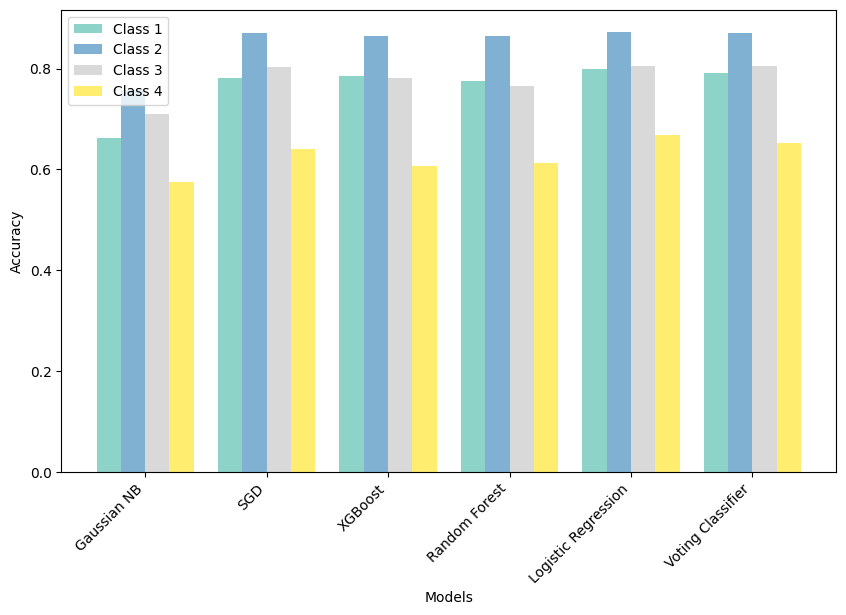

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluation metrics for each model
models = ['Gaussian NB', 'SGD', 'XGBoost', 'Random Forest', 'Logistic Regression', 'Voting Classifier']
accuracy = [accuracy_list, w2v_sgd_acc, w2v_xg_acc, w2v_random_forest_acc, w2v_log_acc, w2v_accuracy_list]

# Number of models
num_models = len(models)

# Number of classes
num_classes = len(accuracy[0])  # Assuming all accuracy lists have the same length

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Width of each bar
bar_width = 0.2

# Indices for the x-axis ticks
index = np.arange(num_models)

# Color map for the bars
color_map = plt.cm.get_cmap('Set3', num_classes)

# Plot the bars
for i in range(num_classes):
    plt.bar(index + (i * bar_width), [accuracy[j][i] for j in range(num_models)], bar_width, label=f'Class {i + 1}', color=color_map(i))

# Set up the x-axis and y-axis labels
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Set up the x-axis tick labels
plt.xticks(index + (bar_width * (num_classes - 1)) / 2, models, rotation=45, ha='right')  # Adjust rotation and alignment

# Add a legend
plt.legend()

# Show the plot
plt.show()


## Find the model with the best accuracy

In [22]:
import numpy as np

# Evaluation metrics for each model
models = ['Gaussian NB', 'SGD', 'XGBoost', 'Random Forest', 'Logistic Regression', 'Voting Classifier']
accuracy = [accuracy_list, w2v_sgd_acc, w2v_xg_acc, w2v_random_forest_acc, w2v_log_acc, w2v_accuracy_list]

# Calculate the average accuracy for each model
avg_accuracy = [np.mean(acc) for acc in accuracy]

# Find the index of the model with the highest average accuracy
best_model_index = np.argmax(avg_accuracy)

# Get the name of the model with the highest average accuracy
best_model = models[best_model_index]

# Print the best model and its average accuracy
print("Overall Best Model:")
print(f"Model Name: {best_model}")
print(f"Average Accuracy: {avg_accuracy[best_model_index]:.2f}")


Overall Best Model:
Model Name: Logistic Regression
Average Accuracy: 0.79


# Visualize Geometric Mean

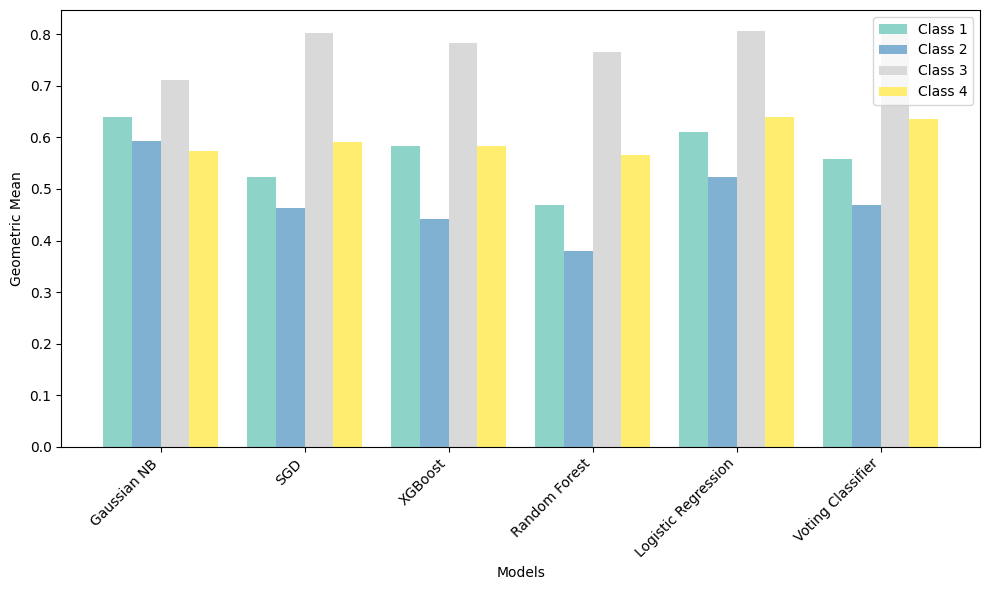

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluation metrics for each model
models = ['Gaussian NB', 'SGD', 'XGBoost', 'Random Forest', 'Logistic Regression', 'Voting Classifier']
gmean = [gmean_list, w2v_sgd_gmean, w2v_xg_gmean, w2v_random_forest_gmean, w2v_log_gmean, w2v_gmean_list]

# Number of models
num_models = len(models)

# Number of classes
num_classes = len(gmean[0])  # Assuming all gmean lists have the same length

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Width of each bar
bar_width = 0.2

# Indices for the x-axis ticks
index = np.arange(num_models)

# Color map for the bars
color_map = plt.cm.get_cmap('Set3', num_classes)

# Plot the bars
for i in range(num_classes):
    plt.bar(index + (i * bar_width), [gmean[j][i] for j in range(num_models)], bar_width, label=f'Class {i + 1}', color=color_map(i))

# Set up the x-axis and y-axis labels
plt.xlabel('Models')
plt.ylabel('Geometric Mean')

# Set up the x-axis tick labels
plt.xticks(index + (bar_width * (num_classes - 1)) / 2, models, rotation=45, ha='right')  # Adjust rotation and alignment

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust the layout
plt.show()




## Find the model with the best Geometric Mean

In [23]:
import numpy as np

# Calculate the average geometric mean for each model
avg_gmean = [np.mean(gm) for gm in gmean]

# Find the index of the model with the highest average geometric mean
best_model_index = np.argmax(avg_gmean)

# Get the name of the model with the highest average geometric mean
best_model = models[best_model_index]

# Print the best model and its average geometric mean
print("Overall Best Model (Geometric Mean):")
print(f"Model Name: {best_model}")
print(f"Average Geometric Mean: {avg_gmean[best_model_index]:.2f}")


Overall Best Model (Geometric Mean):
Model Name: Logistic Regression
Average Geometric Mean: 0.64


# Visualize ROC-AUC

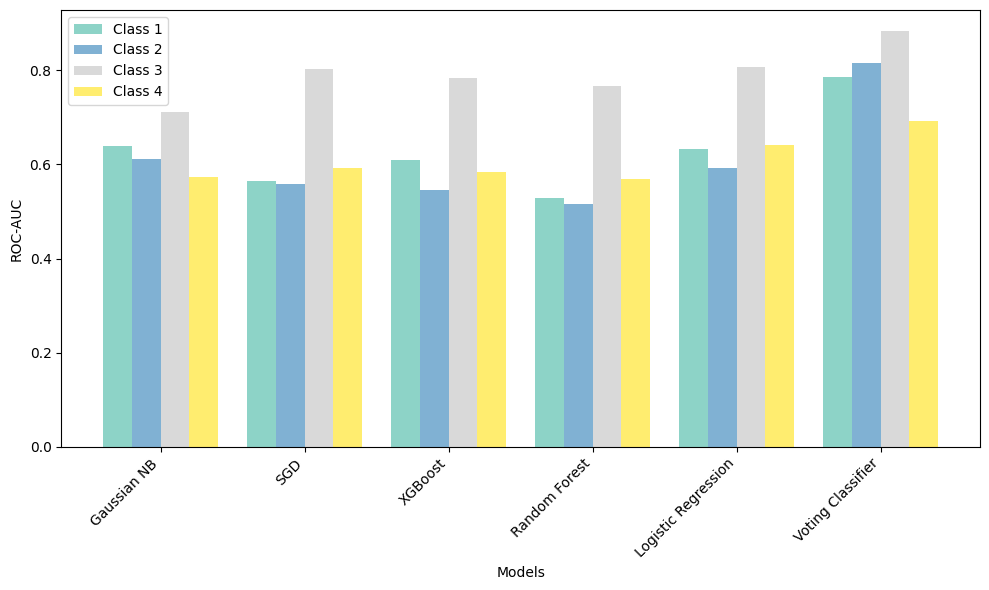

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluation metrics for each model
models = ['Gaussian NB', 'SGD', 'XGBoost', 'Random Forest', 'Logistic Regression', 'Voting Classifier']
roc_auc = [roc_auc_list, w2v_sgd_roc, w2v_xg_roc, w2v_random_forest_roc, w2v_log_roc, w2v_roc_auc_list]

# Number of models
num_models = len(models)

# Number of classes
num_classes = len(roc_auc[0])  # Assuming all roc_auc lists have the same length

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Width of each bar
bar_width = 0.2

# Indices for the x-axis ticks
index = np.arange(num_models)

# Color map for the bars
color_map = plt.cm.get_cmap('Set3', num_classes)

# Plot the bars
for i in range(num_classes):
    plt.bar(index + (i * bar_width), [roc_auc[j][i] for j in range(num_models)], bar_width, label=f'Class {i + 1}', color=color_map(i))

# Set up the x-axis and y-axis labels
plt.xlabel('Models')
plt.ylabel('ROC-AUC')

# Set up the x-axis tick labels
plt.xticks(index + (bar_width * (num_classes - 1)) / 2, models, rotation=45, ha='right')  # Adjust rotation and alignment

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust the layout
plt.show()


## Find the model with the best Geometric Mean

In [30]:
# Calculate average ROC-AUC for each model
average_roc_auc = [np.mean(roc_auc[i]) for i in range(num_models)]

# Find the model with the best ROC-AUC
best_model_index = np.argmax(average_roc_auc)
best_model = models[best_model_index]
best_roc_auc = average_roc_auc[best_model_index]

# Print the best model and its ROC-AUC value
print(f"The model with the best ROC-AUC is {best_model} with a value of {best_roc_auc:.2f}")


The model with the best ROC-AUC is Voting Classifier with a value of 0.79


# Visualize the average precision

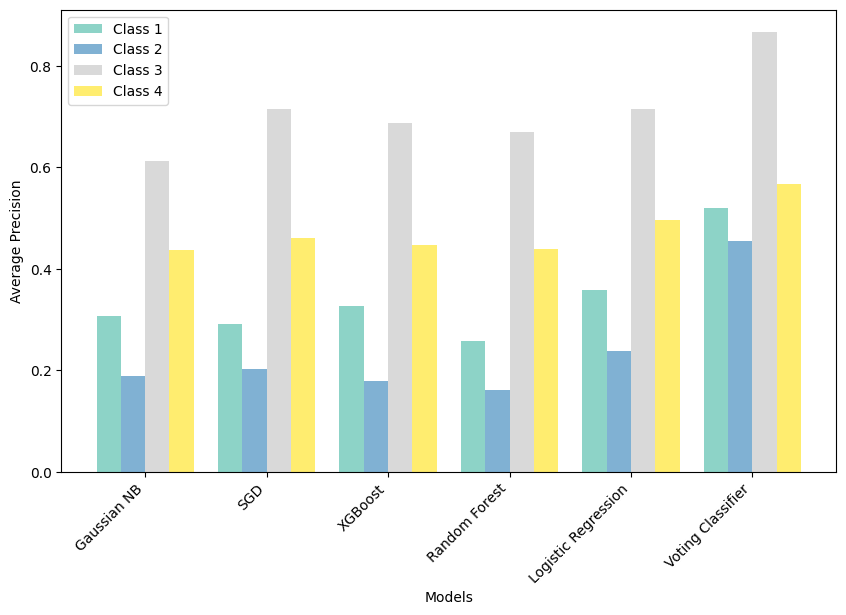

In [31]:
# Evaluation metrics for each model
models = ['Gaussian NB', 'SGD', 'XGBoost', 'Random Forest', 'Logistic Regression', 'Voting Classifier']
avg_precision = [average_precision_list, w2v_sgd_prec, w2v_xg_prec, w2v_random_forest_prec, w2v_log_prec, w2v_average_precision_list]

# Number of models
num_models = len(models)

# Number of classes
num_classes = len(avg_precision[0])  # Assuming all avg_precision lists have the same length

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Width of each bar
bar_width = 0.2

# Indices for the x-axis ticks
index = np.arange(num_models)

# Color map for the bars
color_map = plt.cm.get_cmap('Set3', num_classes)

# Plot the bars
for i in range(num_classes):
    plt.bar(index + (i * bar_width), [avg_precision[j][i] for j in range(num_models)], bar_width, label=f'Class {i + 1}', color=color_map(i))

# Set up the x-axis and y-axis labels
plt.xlabel('Models')
plt.ylabel('Average Precision')

# Set up the x-axis tick labels
plt.xticks(index + (bar_width * (num_classes - 1)) / 2, models, rotation=45, ha='right')

# Add a legend
plt.legend()

# Show the plot
plt.show()


## Find the mode with the best average precision

In [32]:
best_avg_precision = max(avg_precision[0])  # Assuming the first list is the baseline

# Find the index of the model with the best average precision
best_model_index = avg_precision[0].index(best_avg_precision)

# Get the name of the best model
best_model = models[best_model_index]

print(f"The model with the best average precision is: {best_model} (Average Precision: {best_avg_precision:.2f})")


The model with the best average precision is: XGBoost (Average Precision: 0.61)


# Find the best model overall with Word2Vec Vectorizer

In [33]:
# Combine the metrics into a single score (e.g., average or weighted average)
combined_score = (np.mean(accuracy, axis=1) + np.mean(gmean, axis=1) + np.mean(roc_auc, axis=1) + np.mean(avg_precision, axis=1)) / 4

# Find the index of the model with the highest combined score
best_model_index = np.argmax(combined_score)

# Get the name of the best model
best_model = models[best_model_index]

# Print the best model and its corresponding combined score
print(f"The best model overall based on combined metrics is: {best_model} (Combined Score: {combined_score[best_model_index]:.2f})")


The best model overall based on combined metrics is: Voting Classifier (Combined Score: 0.70)


# So the best model overall is Voting Classifier.



---



# Models with TF-IDF vectorizer




## GaussianNB

In [37]:
from imblearn.under_sampling import RandomUnderSampler,TomekLinks

tfidf_nb = make_pipeline(
    preprocesser_tf,
    SparseToDenseTransformer(),
    TomekLinks(),
    GaussianNB()
)

tf_g_accuracy_list, tf_g_gmean_list, tf_g_roc_auc_list, tf_g_average_precision_list  = build_model(tfidf_nb, X, y, "tfidf")





Extrovert vs Introvert
Accuracy: 0.70
Geometric Mean Score: 0.62
ROC-AUC Score: 0.63
Average Precision-Recall Score: 0.30
                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.76      0.49      0.79      0.61      0.38      1322
          1       0.38      0.49      0.76      0.43      0.61      0.36       396

avg / total       0.73      0.70      0.55      0.71      0.61      0.38      1718


Sensing vs Intuition
Accuracy: 0.76
Geometric Mean Score: 0.60
ROC-AUC Score: 0.62
Average Precision-Recall Score: 0.19
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.81      0.42      0.85      0.59      0.36      1481
          1       0.26      0.42      0.81      0.32      0.59      0.33       237

avg / total       0.81      0.76      0.48      0.78      0.59      0.35      1718


Thinking vs Feeling
Accuracy: 0.71
Geometric Mean Score: 0.71
ROC-AUC Score: 0.71
Ave

##  SGD Classifier

In [38]:
from sklearn.linear_model import SGDClassifier

tfidf_sgd = make_pipeline(
    preprocesser_tf, TomekLinks(), SGDClassifier(loss='log', penalty='elasticnet')
)

tf_sgd_acc, tf_sgd_gmean, tf_sgd_roc, tf_sgd_prec = build_model(tfidf_sgd, X, y, "tfidf")



Extrovert vs Introvert
Accuracy: 0.84
Geometric Mean Score: 0.68
ROC-AUC Score: 0.69
Average Precision-Recall Score: 0.47
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.97      0.41      0.90      0.63      0.42      1322
          1       0.80      0.41      0.97      0.55      0.63      0.38       396

avg / total       0.84      0.84      0.54      0.82      0.63      0.41      1718


Sensing vs Intuition
Accuracy: 0.89
Geometric Mean Score: 0.56
ROC-AUC Score: 0.62
Average Precision-Recall Score: 0.32
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.99      0.25      0.94      0.50      0.27      1481
          1       0.88      0.25      0.99      0.39      0.50      0.23       237

avg / total       0.89      0.89      0.35      0.86      0.50      0.26      1718


Thinking vs Feeling
Accuracy: 0.84
Geometric Mean Score: 0.85
ROC-AUC Score: 0.85
Ave

## XGBoost

In [40]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Define the XGBoost classifier pipeline
tfidf_xgboost = make_pipeline(
    preprocesser_tf, TomekLinks(), xgb.XGBClassifier()
)

# Build the model
tf_xg_acc, tf_xg_gmean, tf_xg_roc, tf_xg_prec  = build_model(tfidf_xgboost, X, y, "tfidf")



Extrovert vs Introvert
Accuracy: 0.85
Geometric Mean Score: 0.72
ROC-AUC Score: 0.73
Average Precision-Recall Score: 0.50
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.94      0.52      0.90      0.70      0.51      1322
          1       0.74      0.52      0.94      0.61      0.70      0.47       396

avg / total       0.84      0.85      0.62      0.84      0.70      0.50      1718


Sensing vs Intuition
Accuracy: 0.90
Geometric Mean Score: 0.67
ROC-AUC Score: 0.70
Average Precision-Recall Score: 0.41
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.98      0.43      0.95      0.65      0.44      1481
          1       0.78      0.43      0.98      0.55      0.65      0.39       237

avg / total       0.90      0.90      0.50      0.89      0.65      0.43      1718


Thinking vs Feeling
Accuracy: 0.83
Geometric Mean Score: 0.83
ROC-AUC Score: 0.83
Ave

## Random Forest Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier

tfidf_random_forest = make_pipeline(
    preprocesser_tf, TomekLinks(), RandomForestClassifier(n_estimators=100, random_state=42),
)

tf_random_forest_acc, tf_random_forest_gmean, tf_random_forest_roc, tf_random_forest_prec = build_model(tfidf_random_forest, X, y, "tfidf")



Extrovert vs Introvert
Accuracy: 0.79
Geometric Mean Score: 0.48
ROC-AUC Score: 0.54
Average Precision-Recall Score: 0.29
                   pre       rec       spe        f1       geo       iba       sup

          0       0.78      1.00      0.09      0.88      0.29      0.09      1322
          1       0.87      0.09      1.00      0.16      0.29      0.08       396

avg / total       0.80      0.79      0.30      0.71      0.29      0.09      1718


Sensing vs Intuition
Accuracy: 0.86
Geometric Mean Score: 0.36
ROC-AUC Score: 0.51
Average Precision-Recall Score: 0.15
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      1.00      0.01      0.93      0.11      0.01      1481
          1       1.00      0.01      1.00      0.02      0.11      0.01       237

avg / total       0.88      0.86      0.15      0.80      0.11      0.01      1718


Thinking vs Feeling
Accuracy: 0.80
Geometric Mean Score: 0.80
ROC-AUC Score: 0.80
Ave

## *Logistic Regression*

In [ ]:
tfidf_logistic_regression = make_pipeline(
    preprocesser_tf,TomekLinks(),LogisticRegressionCV(Cs=[0.1, 1, 10], cv=5)
)
# Call the build_model function with the provided values


tf_log_acc, tf_log_gmean, tf_log_roc, tf_log_prec = build_model(tfidf_logistic_regression, X, y, "tfidf")


Extrovert vs Introvert
Accuracy: 0.84
Geometric Mean Score: 0.72
ROC-AUC Score: 0.73
Average Precision-Recall Score: 0.49
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.94      0.53      0.90      0.70      0.51      1322
          1       0.72      0.53      0.94      0.61      0.70      0.47       396

avg / total       0.83      0.84      0.62      0.83      0.70      0.50      1718


Sensing vs Intuition
Accuracy: 0.92
Geometric Mean Score: 0.72
ROC-AUC Score: 0.74
Average Precision-Recall Score: 0.47
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.98      0.49      0.95      0.70      0.51      1481
          1       0.82      0.49      0.98      0.62      0.70      0.46       237

avg / total       0.91      0.92      0.56      0.91      0.70      0.50      1718


Thinking vs Feeling
Accuracy: 0.84
Geometric Mean Score: 0.84
ROC-AUC Score: 0.84
Ave

## Voting Classifier

In [44]:
from sklearn.ensemble import VotingClassifier

tf_accuracy_list = []
tf_gmean_list = []
tf_roc_auc_list = []
tf_average_precision_list = []

# Create the Voting classifier
voting_classifier = VotingClassifier([
    ('tf_xgboost', tfidf_xgboost),
    ('tf_sdg',tfidf_sgd),
    ('tf_logistic_regression', tfidf_logistic_regression),

], voting='soft')


for col in y.columns:

        print(f"\n{mbti_type[col]}")
        target = y[col]

        X_train, X_test, y_train, y_test = train_test_split(
            X, target, test_size=0.2, random_state=42, stratify=target
        )
        # Train the Voting classifier
        voting_classifier.fit(X_train, y_train)

        # y_hat
        y_pred = voting_classifier.predict(X_test)

        # y_probability
        y_proba = voting_classifier.predict_proba(X_test)[:, 1]

        # precision recall score
        tf_average_precision = average_precision_score(y_test, y_proba)
        tf_average_precision_list.append(tf_average_precision)

        # model evaluation
        tf_accuracy = accuracy_score(y_test, y_pred)
        tf_accuracy_list.append(tf_accuracy)

        tf_gmean = geometric_mean_score(y_test, y_pred, average='weighted')
        tf_gmean_list.append(tf_gmean)

        tf_roc_auc = roc_auc_score(y_test, y_proba)
        tf_roc_auc_list.append(tf_roc_auc)




        print(f"Accuracy: {tf_accuracy:.2f}")
        print(f"Geometric Mean Score: {tf_gmean:.2f}")
        print(f"ROC-AUC Score: {tf_roc_auc:.2f}")
        print(f"Average Precision-Recall Score: {tf_average_precision:.2f}")
        print(classification_report_imbalanced(y_test, y_pred))



Extrovert vs Introvert
Accuracy: 0.85
Geometric Mean Score: 0.72
ROC-AUC Score: 0.89
Average Precision-Recall Score: 0.73
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.96      0.51      0.91      0.70      0.51      1322
          1       0.77      0.51      0.96      0.61      0.70      0.47       396

avg / total       0.85      0.85      0.61      0.84      0.70      0.50      1718


Sensing vs Intuition
Accuracy: 0.92
Geometric Mean Score: 0.72
ROC-AUC Score: 0.92
Average Precision-Recall Score: 0.73
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.98      0.50      0.95      0.70      0.51      1481
          1       0.84      0.50      0.98      0.62      0.70      0.47       237

avg / total       0.91      0.92      0.57      0.91      0.70      0.51      1718


Thinking vs Feeling
Accuracy: 0.85
Geometric Mean Score: 0.85
ROC-AUC Score: 0.92
Ave

# Visualiazing accuracy with TF-IDF vectorizer

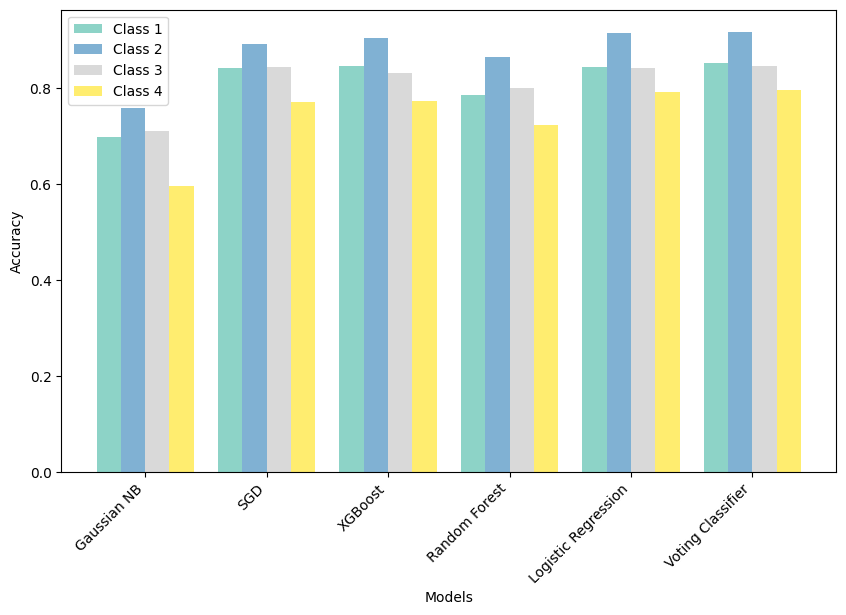

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluation metrics for each model
models = ['Gaussian NB', 'SGD', 'XGBoost', 'Random Forest', 'Logistic Regression', 'Voting Classifier']
accuracy = [tf_g_accuracy_list, tf_sgd_acc, tf_xg_acc, tf_random_forest_acc, tf_log_acc, tf_accuracy_list]

# Number of models
num_models = len(models)

# Number of classes
num_classes = len(accuracy[0])  # Assuming all accuracy lists have the same length

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Width of each bar
bar_width = 0.2

# Indices for the x-axis ticks
index = np.arange(num_models)

# Color map for the bars
color_map = plt.cm.get_cmap('Set3', num_classes)

# Plot the bars
for i in range(num_classes):
    plt.bar(index + (i * bar_width), [accuracy[j][i] for j in range(num_models)], bar_width, label=f'Class {i + 1}', color=color_map(i))

# Set up the x-axis and y-axis labels
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Set up the x-axis tick labels
plt.xticks(index + (bar_width * (num_classes - 1)) / 2, models, rotation=45, ha='right')  # Adjust rotation and alignment

# Add a legend
plt.legend()

# Show the plot
plt.show()


## Finding the model with the best overall accuracy.

In [46]:
import numpy as np

# Evaluation metrics for each model
models = ['Gaussian NB', 'SGD', 'XGBoost', 'Random Forest', 'Logistic Regression', 'Voting Classifier']
accuracy = [tf_g_accuracy_list, tf_sgd_acc, tf_xg_acc, tf_random_forest_acc, tf_log_acc, tf_accuracy_list]

# Calculate the average accuracy for each model
avg_accuracy = [np.mean(acc) for acc in accuracy]

# Find the index of the model with the highest average accuracy
best_model_index = np.argmax(avg_accuracy)

# Get the name of the model with the highest average accuracy
best_model = models[best_model_index]

# Print the best model and its average accuracy
print("Overall Best Model:")
print(f"Model Name: {best_model}")
print(f"Average Accuracy: {avg_accuracy[best_model_index]:.2f}")


Overall Best Model:
Model Name: Voting Classifier
Average Accuracy: 0.85


# Visualize Geometric Mean scores with TF-IDF vectorizer


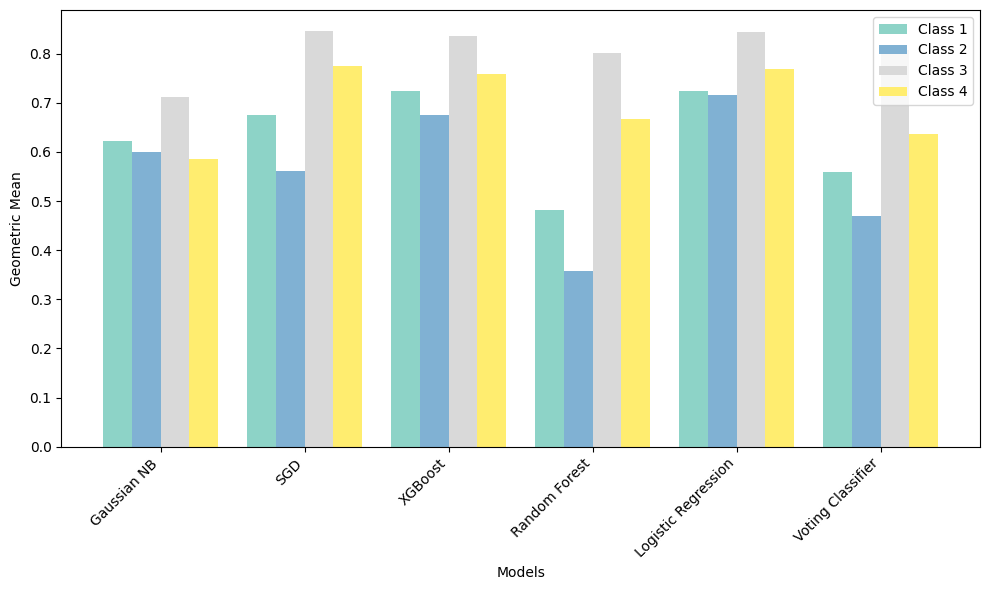

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluation metrics for each model
models = ['Gaussian NB', 'SGD', 'XGBoost', 'Random Forest', 'Logistic Regression', 'Voting Classifier']
gmean = [tf_g_gmean_list, tf_sgd_gmean, tf_xg_gmean, tf_random_forest_gmean, tf_log_gmean, w2v_gmean_list]

# Number of models
num_models = len(models)

# Number of classes
num_classes = len(gmean[0])  # Assuming all gmean lists have the same length

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Width of each bar
bar_width = 0.2

# Indices for the x-axis ticks
index = np.arange(num_models)

# Color map for the bars
color_map = plt.cm.get_cmap('Set3', num_classes)

# Plot the bars
for i in range(num_classes):
    plt.bar(index + (i * bar_width), [gmean[j][i] for j in range(num_models)], bar_width, label=f'Class {i + 1}', color=color_map(i))

# Set up the x-axis and y-axis labels
plt.xlabel('Models')
plt.ylabel('Geometric Mean')

# Set up the x-axis tick labels
plt.xticks(index + (bar_width * (num_classes - 1)) / 2, models, rotation=45, ha='right')  # Adjust rotation and alignment

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust the layout
plt.show()






## Find the model with the best overall geometric mean score

In [50]:
import numpy as np

# Evaluation metrics for each model
models = ['Gaussian NB', 'SGD', 'XGBoost', 'Random Forest', 'Logistic Regression', 'Voting Classifier']
gmean = [tf_g_gmean_list, tf_sgd_gmean, tf_xg_gmean, tf_random_forest_gmean, tf_log_gmean, w2v_gmean_list]

# Calculate the average accuracy for each model
avg_gmean = [np.mean(gm) for gm in gmean]

# Find the index of the model with the highest average accuracy
best_model_index = np.argmax(avg_gmean)

# Get the name of the model with the highest average accuracy
best_model = models[best_model_index]

# Print the best model and its average accuracy
print("Overall Best Model:")
print(f"Model Name: {best_model}")
print(f"Average Accuracy: {avg_gmean[best_model_index]:.2f}")


Overall Best Model:
Model Name: Logistic Regression
Average Accuracy: 0.76


# Visualizing the ROC-AUC metrics

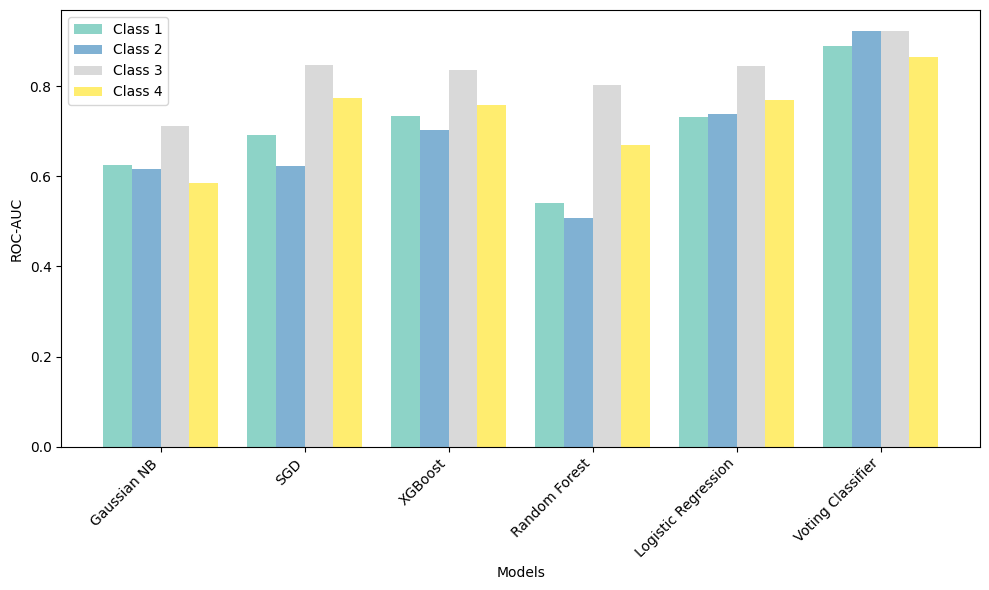

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluation metrics for each model
models = ['Gaussian NB', 'SGD', 'XGBoost', 'Random Forest', 'Logistic Regression', 'Voting Classifier']
roc_auc = [tf_g_roc_auc_list, tf_sgd_roc, tf_xg_roc, tf_random_forest_roc, tf_log_roc, tf_roc_auc_list]

# Number of models
num_models = len(models)

# Number of classes
num_classes = len(roc_auc[0])  # Assuming all roc_auc lists have the same length

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Width of each bar
bar_width = 0.2

# Indices for the x-axis ticks
index = np.arange(num_models)

# Color map for the bars
color_map = plt.cm.get_cmap('Set3', num_classes)

# Plot the bars
for i in range(num_classes):
    plt.bar(index + (i * bar_width), [roc_auc[j][i] for j in range(num_models)], bar_width, label=f'Class {i + 1}', color=color_map(i))

# Set up the x-axis and y-axis labels
plt.xlabel('Models')
plt.ylabel('ROC-AUC')

# Set up the x-axis tick labels
plt.xticks(index + (bar_width * (num_classes - 1)) / 2, models, rotation=45, ha='right')  # Adjust rotation and alignment

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust the layout
plt.show()


## Find the model with the best overall ROC-AUC metrics



In [54]:
import numpy as np

# Evaluation metrics for each model
models = ['Gaussian NB', 'SGD', 'XGBoost', 'Random Forest', 'Logistic Regression', 'Voting Classifier']
roc_auc = [tf_g_roc_auc_list, tf_sgd_roc, tf_xg_roc, tf_random_forest_roc, tf_log_roc, tf_roc_auc_list]

# Calculate the average accuracy for each model
average_roc_auc = [np.mean(roc) for roc in roc_auc]

# Find the index of the model with the highest average accuracy
best_model_index = np.argmax(average_roc_auc)

# Get the name of the model with the highest average accuracy
best_model = models[best_model_index]

# Print the best model and its average accuracy
print("Overall Best Model:")
print(f"Model Name: {best_model}")
print(f"Average Accuracy: {average_roc_auc[best_model_index]:.2f}")


Overall Best Model:
Model Name: Voting Classifier
Average Accuracy: 0.90


# Visualize the average precision metric with the TF-IDF vectorizer

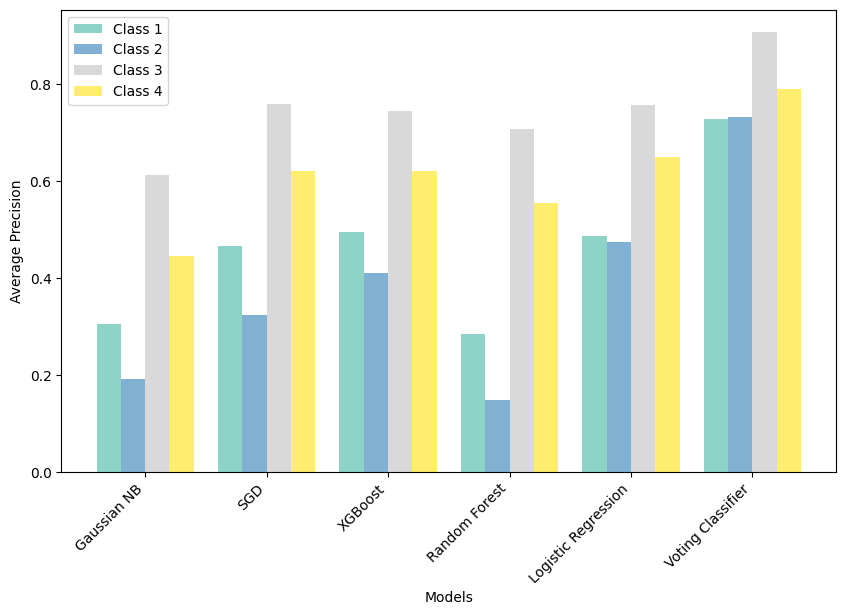

In [55]:
# Evaluation metrics for each model
models = ['Gaussian NB', 'SGD', 'XGBoost', 'Random Forest', 'Logistic Regression', 'Voting Classifier']
avg_precision = [tf_g_average_precision_list, tf_sgd_prec, tf_xg_prec, tf_random_forest_prec, tf_log_prec, tf_average_precision_list]

# Number of models
num_models = len(models)

# Number of classes
num_classes = len(avg_precision[0])  # Assuming all avg_precision lists have the same length

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Width of each bar
bar_width = 0.2

# Indices for the x-axis ticks
index = np.arange(num_models)

# Color map for the bars
color_map = plt.cm.get_cmap('Set3', num_classes)

# Plot the bars
for i in range(num_classes):
    plt.bar(index + (i * bar_width), [avg_precision[j][i] for j in range(num_models)], bar_width, label=f'Class {i + 1}', color=color_map(i))

# Set up the x-axis and y-axis labels
plt.xlabel('Models')
plt.ylabel('Average Precision')

# Set up the x-axis tick labels
plt.xticks(index + (bar_width * (num_classes - 1)) / 2, models, rotation=45, ha='right')

# Add a legend
plt.legend()

# Show the plot
plt.show()


## Find the model with the best overall Average Precision


In [58]:
import numpy as np

# Evaluation metrics for each model
models = ['Gaussian NB', 'SGD', 'XGBoost', 'Random Forest', 'Logistic Regression', 'Voting Classifier']
avg_precision = [tf_g_average_precision_list, tf_sgd_prec, tf_xg_prec, tf_random_forest_prec, tf_log_prec, tf_average_precision_list]

# Calculate the average accuracy for each model
average_precision = [np.mean(pre) for pre in avg_precision]

# Find the index of the model with the highest average accuracy
best_model_index = np.argmax(average_precision)

# Get the name of the model with the highest average accuracy
best_model = models[best_model_index]

# Print the best model and its average accuracy
print("Overall Best Model:")
print(f"Model Name: {best_model}")
print(f"Average Accuracy: {average_precision[best_model_index]:.2f}")

Overall Best Model:
Model Name: Voting Classifier
Average Accuracy: 0.79


# Find the best model overall

In [59]:
# Combine the metrics into a single score (e.g., average or weighted average)
combined_score = (np.mean(accuracy, axis=1) + np.mean(gmean, axis=1) + np.mean(roc_auc, axis=1) + np.mean(avg_precision, axis=1)) / 4

# Find the index of the model with the highest combined score
best_model_index = np.argmax(combined_score)

# Get the name of the best model
best_model = models[best_model_index]

# Print the best model and its corresponding combined score
print(f"The best model overall based on combined metrics is: {best_model} (Combined Score: {combined_score[best_model_index]:.2f})")


The best model overall based on combined metrics is: Voting Classifier (Combined Score: 0.79)




---

So after testing the models the model that is best in all the metrics overall is the Voting Classifier using XGBoost classifier, SGD classifier and Logistic Regression using the TF-IDF vectorizer.